# Principal Component Analysis as an Example of Factor Model

## 基于主成分分析的因子模型:  
(1) 使用主成分分析 (PCA) 方法, 从 600 种股票日收益率数据中提取公共的主要风险因子(因子收益)。  
(2) 基于这些因子建立各股票的收益率的线性回归模型, 预测各股票的"正常"收益率。  
(3) 做多过去一段时间累计预测收益率最好的股票, 做空过去一段时间累计预测收益率最差的股票（动量趋势策略）。  
(4) 计算该策略的部分回测指标。  

In [20]:
import math
#import time

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from calculateMaxDD import calculateMaxDD
#from sklearn.preprocessing import StandardScaler
#from sklearn import linear_model
#from sklearn.linear_model import Ridge
#from numpy.linalg import eig
#from numpy.linalg import eigh
#from statsmodels.api import OLS

## 1. 数据准备和预处理
- 设置基本参数: <br>
  lookback : 训练期时段天数, 252<br>
  numFactors : 主成分因子个数, 5<br>
  topN : 每天做多/做空的股票支数, 50<br>
- df : 标普 600 小盘股的历史股价<br>
  是带日期索引的 DataFrame, 1006 行(天), 600 列(股数) 
- dailyRet : 股票的日收益率数据<br>
  是带日期索引的 DataFrame, 1006 行(天), 600列(股数)
- positionsTable : 头寸(仓位)表<br>
  二维数组, 1006 行(天), 600 列(股数), 用于存储每支股票在每一天的持仓数, 初始值均是 0 (空仓)
- end_index : 循环截止的索引号<br>
  等于天数 1006  

In [2]:
lookback = 252   # 训练期，使用过去252个交易日的数据
numFactors = 5   # 使用5个主成分作为因子
topN = 50   # 做多/做空各50支股票

df = pd.read_table('IJR_20080114.txt')   # txt文件内容：2004-01-15 至 2008-01-14 共 1006 个交易日的 标普600小盘股 的股价
df['Date'] = df['Date'].astype('int')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.ffill(inplace=True)   # forward fill 向前填充，若某单元格为NaN（无效数据），则以其上一个单元格（上一行、同列的单元格）值填充

dailyRet = df.pct_change()   
positionsTable = np.zeros(df.shape)   
end_index = df.shape[0]  

In [3]:
df

,ABCW,ABFS,ABM,ACAT,ACLS,ACO,ACTL,ADPT,AEIS,AGL,...,WTS,WW,WWW,WXS,XRIT,ZEP,ZLC,ZNT,ZQK,ZUMZ
Date,,,,,,,,,,,,,,,,,,,,,
20040115,22.1609,30.9237,16.4747,26.4522,11.32,23.3373,26.93,10.10,27.430,21.6689,...,22.6328,24.3135,13.8953,NaN,11.8467,NaN,26.115,19.7760,8.865,NaN
20040116,22.2135,30.2284,16.4129,25.7508,12.56,19.5716,27.92,10.50,27.390,21.5655,...,22.2980,23.9795,13.7789,NaN,11.9759,NaN,26.015,19.7346,8.970,NaN
20040120,22.6166,30.6230,16.5188,26.3465,13.22,22.5940,28.00,11.05,27.500,21.1893,...,22.4851,24.2447,13.6109,NaN,12.6120,NaN,26.125,20.9153,8.965,NaN
20040121,22.7393,30.9425,16.4394,26.4128,12.77,20.7356,27.00,10.68,26.780,21.1046,...,22.5540,24.0188,13.6368,NaN,12.7014,NaN,26.200,20.8976,8.935,NaN
20040122,22.6867,31.4311,16.2541,25.6153,12.23,20.0216,27.05,10.18,25.578,20.9259,...,22.6033,24.1858,13.4623,NaN,12.6815,NaN,26.760,20.7441,8.775,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20080108,21.1800,18.2800,19.0500,8.1200,4.25,32.4300,12.20,3.13,10.550,18.0000,...,27.0800,43.1000,21.3100,34.00,11.2400,13.55,15.270,42.5800,7.491,16.3100
20080109,21.7200,18.9200,19.1101,7.6800,4.28,33.3600,12.52,3.29,10.630,18.0700,...,27.1000,43.3100,22.0300,32.96,11.3484,13.54,14.780,43.4700,7.820,17.1576
20080110,22.2800,18.9600,19.3400,8.2800,4.38,33.0400,12.44,3.25,11.230,18.1400,...,27.9200,44.3200,21.8100,33.12,11.4500,14.54,14.350,43.6200,8.020,17.5600


In [4]:
dailyRet

,ABCW,ABFS,ABM,ACAT,ACLS,ACO,ACTL,ADPT,AEIS,AGL,...,WTS,WW,WWW,WXS,XRIT,ZEP,ZLC,ZNT,ZQK,ZUMZ
Date,,,,,,,,,,,,,,,,,,,,,
20040115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20040116,0.002374,-0.022484,-0.003751,-0.026516,0.109541,-0.161360,0.036762,0.039604,-0.001458,-0.004772,...,-0.014793,-0.013737,-0.008377,NaN,0.010906,NaN,-0.003829,-0.002093,0.011844,NaN
20040120,0.018147,0.013054,0.006452,0.023133,0.052548,0.154428,0.002865,0.052381,0.004016,-0.017445,...,0.008391,0.011059,-0.012193,NaN,0.053115,NaN,0.004228,0.059829,-0.000557,NaN
20040121,0.005425,0.010433,-0.004807,0.002516,-0.034039,-0.082252,-0.035714,-0.033484,-0.026182,-0.003997,...,0.003064,-0.009318,0.001903,NaN,0.007088,NaN,0.002871,-0.000846,-0.003346,NaN
20040122,-0.002313,0.015791,-0.011272,-0.030194,-0.042287,-0.034434,0.001852,-0.046816,-0.044884,-0.008467,...,0.002186,0.006953,-0.012796,NaN,-0.001567,NaN,0.021374,-0.007345,-0.017907,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20080108,-0.049372,-0.054320,-0.022074,-0.096774,-0.044944,-0.038256,-0.030977,-0.027950,-0.037409,-0.013699,...,-0.035956,-0.024666,-0.027385,-0.018759,-0.005310,-0.014545,0.015968,-0.048279,-0.030918,-0.035864
20080109,0.025496,0.035011,0.003155,-0.054187,0.007059,0.028677,0.026230,0.051118,0.007583,0.003889,...,0.000739,0.004872,0.033787,-0.030588,0.009644,-0.000738,-0.032089,0.020902,0.043919,0.051968
20080110,0.025783,0.002114,0.012030,0.078125,0.023364,-0.009592,-0.006390,-0.012158,0.056444,0.003874,...,0.030258,0.023320,-0.009986,0.004854,0.008953,0.073855,-0.029093,0.003451,0.025575,0.023453


## 2. 计算头寸（仓位）
循化计算得到索引号从 lookback+1 (这里是253) 至 end_index-1 (这里是1005) 每一天的头寸(仓位), 具体如下:<br>
(1) 每天提取所有 600 种股票在此之前最新的 lookback (这里是252) 条历史日收益率数据作为训练集, 转置后赋予变量 R <br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; R 是 DataFrame 类型, 600 行(股数), 252 列(天), <br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; 在处理过程中需剔除缺数据的股票, 因此, 行数(股数)可能会小于600。<br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; 变量 hasData 是一维数组，用于存储训练集 R 中所有不包含 NaN 的行(股票)的行索引号(对应某一支股票)。<br>
(2) 使用主成分分析 (PCA) 方法, 对训练集中的各股票的252天的日收益率数据进行分析计算, <br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; 得到所有这些股票所共有的主要风险因子(因子收益), 作为属性值, 赋予变量 X <br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; X 是 二维数组, 252 行(天), 6 列 (其中首列是常数项1, 主成分因子个数是5)。 <br>
(3) 把 600 (实际可能少于600) 种股票的训练集中的日收益率数据, 作为标签值, 赋予变量 Y <br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Y 是 DataFrame 类型, 252 行(天), 600 列(实际可能少于600)。 <br>
(4) 创建线性回归模型 Y = X W + ε, 拟合计算得到各股票的各因子的权重 W, 赋予变量 clf <br>
(5) 通过所得到的各股票的回归模型 clf, 根据共有的风险因子(因子收益) X, 计算各股票在之前252天的每一天的拟合值, <br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; 把各股票这252天拟合值分别求和, 作为各股票预测的累计涨跌幅指标, 赋予变量 cumExpRet <br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; cumExpRet 是一维数组, 其长度为 600(实际可能少于600)。 <br>
(6) 把预测的累计涨跌幅指标 cumExpRet 从小到大排序, 做空最前面 50 种股票, 做多最后面50种股票, <br>
&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; 据此修改头寸(仓位)表 positionsTable 中该天所对应股票的头寸(仓位)。 <br>

In [5]:
for t in np.arange(lookback + 1, end_index):    # 从第 lookback+1 日开始，每一日都要重新建模
    if (t % 50 == 0):
        print(str(t),  '/', str(end_index))   # 显示训练进度
    R = dailyRet.iloc[t - lookback : t,].T    # R 每一行对应一支股票，每一列对应一天
    hasData = np.where(R.notna().all(axis = 1))[0]    # hasData 是一维数组，是 R 中所有不包含 NaN 的行的行索引号（对应某一支股票）
    R.dropna(inplace = True)   # 删除 NaN（无效数据）单元格所在的行，即删除对应整支股票
    pca = PCA()  # 调用主成分分析，本例中的因子收益是通过主成分分析得到的
    X = pca.fit_transform(R.T)[:, :numFactors]  # X 是主成分（因子），每一行对应一天，每一列是一个因子
    X = sm.add_constant(X)  # 把常数项 1 插入到 X 的首列，这样后续回归计算将会得到常数项 1 对应的系数(即常数项值)
    Y = R.T    # y1 是 DataFrame, 每一行对应一天，每一列对应一支股票
    clf = MultiOutputRegressor(LinearRegression(fit_intercept = False), n_jobs = 4).fit(X, Y)  # 创建并拟合得到各股票的线性回归模型 
    cumExpRet = np.sum(clf.predict(X), axis=0)    # 对每支股票在训练时段内每一天的模型预测的收益率值求和，以此作为该股票在该时间段所预测的累计涨跌幅指标
    idxSort = cumExpRet.argsort()  # 按各股票预测的累计涨跌幅指标从小到大排序所对应的股票索引
    positionsTable[t, hasData[idxSort[np.arange(0, topN)]]] = -1    # 对应 topN 支股票在训练时段预测的累计跌幅最大，按趋势预计还要跌，所以做空。
    positionsTable[t, hasData[idxSort[np.arange(-topN, 0)]]] = 1    # 对应 topN 支股票在训练时段预测的累计涨幅最大，按趋势预计还要涨，所以做多。


300 / 1006
350 / 1006
400 / 1006
450 / 1006
500 / 1006
550 / 1006
600 / 1006
650 / 1006
700 / 1006
750 / 1006
800 / 1006
850 / 1006
900 / 1006
950 / 1006
1000 / 1006


In [6]:
positionsTable

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1006, 600))

## 3. 计算不计交易成本的回测指标

### 计算夏普比率
- 计算每一天的总资本(等于持仓数的绝对值的和)<br>
  由于持仓数的行索引号 i 对应的是 dailyRet 第 i + 1 行的回报率, 因此需要对 positions 做 shift(), 下移一行<br>
- 计算日回报率 (未扣除交易成本)<br>
  由于持仓数的行索引号 i 对应的是 dailyRet 第 i + 1 行的回报率, 因此需要对 positions 做 shift(), 下移一行<br>
- 计算年化回报率<br>
  年化回报率 = 日均回报率 X 252
- 计算年化回报波动率<br>
  年化回报波动率 = 日回报波动率 X sqrt(252)
- 计算年化夏普比例<br>
  年化夏普比例 = 年化回报率 / 年化回报波动率

In [7]:
capital = np.nansum(np.array(abs(pd.DataFrame(positionsTable)).shift()), axis=1)  
positionsTable[capital==0,] = 0   # 把 capital 值为 0 元素对应行（天）的全部持仓数均置为 0 
capital[capital==0] = 1  # 避免下面除以 0
ret = np.nansum(np.array(pd.DataFrame(positionsTable).shift()) * np.array(dailyRet), axis=1) / capital  
avgRet = np.nanmean(ret) * 252   # 年化回报率
avgStdRet = np.nanstd(ret) * math.sqrt(252)   # 年化回报波动率
sharpe = avgRet / avgStdRet   # 夏普比例
print(avgRet)
print(avgStdRet)
print(sharpe)


0.037391700107206736
0.07020510061321517
0.532606602377951


In [8]:
ret

array([ 0.        ,  0.        ,  0.        , ..., -0.00867741,
        0.00102143, -0.00088955], shape=(1006,))

### 计算最大回撤

In [18]:
cumRet = np.cumprod(1.0 + ret) - 1.0
maxDD, maxDDD, i = calculateMaxDD(cumRet)

print("Max Drawdown:", float(maxDD))
print("Max Drawdown Duration (days):", int(maxDDD))

Max Drawdown: -0.10918152589646912
Max Drawdown Duration (days): 487


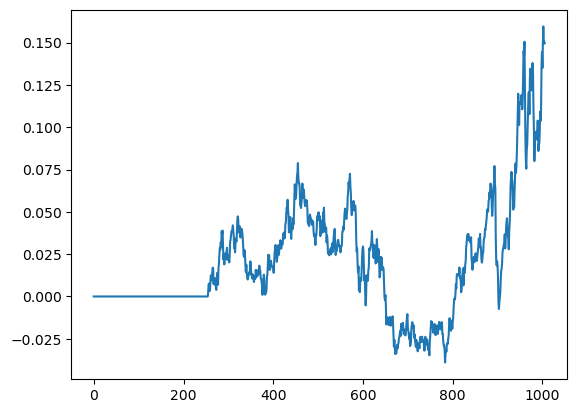

In [21]:
plt.plot(cumRet)  # 绘制累积收益率（水位线）图